In [75]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools as it

from glob import glob
from sklearn.model_selection import train_test_split

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [76]:
batch_size = 32

img_height = 128
img_width = 128
img_channels = 3

path_to_train = 'comp-540-spring-2019/train'

glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)

In [77]:
def get_img_id(img_path):
    
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

def image_gen(img_paths, img_size=(img_height, img_width)):

    for img_path in img_paths:
        
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        img = imread(img_path) / 255.
        mask = rgb2gray(imread(mask_path))
        
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        mask = (mask >= 0.5).astype(float)
        
        ####
        
        # Preprocessing code here
        
        ####
        
        yield img, mask

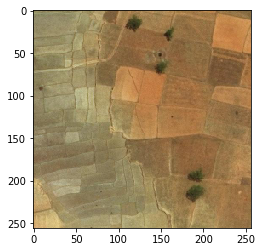

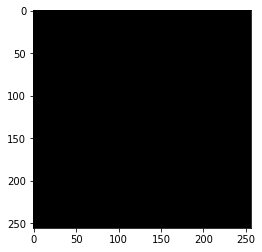

In [78]:
ig = image_gen(train_img_paths)

first_img, first_mask = next(ig)

plt.imshow(first_img)
plt.show()
plt.imshow(first_mask, cmap='gray')
plt.show()

In [5]:
smooth = 1e-9

def dice_coef(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    return score

In [6]:
# Generally, decrease (x,y) by factor 2 => Increase (z) by factor 2

inputs = Input((img_height, img_width, img_channels))
s = Lambda(lambda x: x / 255) (inputs)

n = 1 # can use this as a performance complexity lever

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
def image_batch_generator(img_paths, batchsize=batch_size):
    
    while True:
        
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:

            batch_img.append(img)
            batch_mask.append(mask)

            if len(batch_img) == batchsize:
                
                yield np.stack(batch_img, axis=0), np.expand_dims(np.stack(batch_mask, axis=0),axis = -1)
                batch_img, batch_mask = [], []
        
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.expand_dims(np.stack(batch_mask, axis=0),axis = -1)
            batch_img, batch_mask = [], []

In [8]:
traingen = image_batch_generator(train_img_paths, batchsize=batch_size)

image, mask = next(traingen)
print(image.shape)
print(mask.shape)

(32, 128, 128, 3)
(32, 128, 128, 1)


In [9]:
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.3)

traingen = image_batch_generator(train_img_paths, batchsize=batch_size)
valgen = image_batch_generator(val_img_paths, batchsize=batch_size)

def calc_steps(data_len, batchsize):
    
    return (data_len + batchsize - 1) // batchsize

train_steps = calc_steps(len(train_img_paths), batch_size)
val_steps = calc_steps(len(val_img_paths), batch_size)



earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-comp540-project.h5', verbose=1, save_best_only=True)

results = model.fit_generator(
    
    generator=traingen,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=valgen,
    validation_steps=val_steps,
    verbose=1,
    callbacks=[earlystopper, checkpointer]
    
)

Epoch 1/50
239/239 [==============================] - 686s 3s/step - loss: 0.1772 - dice_coef: 0.0011 - val_loss: 0.1664 - val_dice_coef: 1.0271e-13

Epoch 00001: val_loss improved from inf to 0.16635, saving model to model-comp540-project.h5
Epoch 2/50
239/239 [==============================] - 646s 3s/step - loss: 0.1640 - dice_coef: 1.0437e-13 - val_loss: 0.1654 - val_dice_coef: 1.0271e-13

Epoch 00002: val_loss improved from 0.16635 to 0.16543, saving model to model-comp540-project.h5
Epoch 3/50
239/239 [==============================] - 644s 3s/step - loss: 0.1603 - dice_coef: 1.0437e-13 - val_loss: 0.1583 - val_dice_coef: 1.0271e-13

Epoch 00003: val_loss improved from 0.16543 to 0.15825, saving model to model-comp540-project.h5
Epoch 4/50
239/239 [==============================] - 647s 3s/step - loss: 0.1546 - dice_coef: 2.5121e-05 - val_loss: 0.1548 - val_dice_coef: 1.8665e-04

Epoch 00004: val_loss improved from 0.15825 to 0.15478, saving model to model-comp540-project.h5
Epoc

In [27]:
# Create submission DataFrame
def create_submission(csv_name, predictions, image_ids):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> numpyarray of size (num_examples, height, width)
                In this case (num_examples, 512, 512)
    image_ids -> numpyarray or list of size (num_examples,)
    
    predictions[i] should be the prediction of road for image_id[i]
    """
    sub = pd.DataFrame()
    sub['ImageId'] = image_ids
    encodings = []
    num_images = len(image_ids)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        encodings.append(rle_encoding(predictions[i]))
        
    sub['EncodedPixels'] = encodings
    #sub['Height'] = [512]*num_images Nonger needed for DICE Scoring
    #sub['Width'] = [512]*num_images Nonger needed for DICE Scoring
    sub.to_csv(csv_name, index=False)

In [28]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [95]:
def test_image_gen(img_paths, img_size=(128, 128)):

    for img_path in img_paths:
        
        img_id = get_img_id(img_path)
        
        img = imread(img_path) / 255.
        
        img = resize(img, img_size, preserve_range=True)
        
        img = np.expand_dims(img, axis=0)
        
        yield img
        
def test_generator(img_paths, batchsize = batch_size):
    
    while True:
        
        ig = test_image_gen(img_paths)
        batch_img = []
        
        for img in ig:

            batch_img.append(img)

            if len(batch_img) == batchsize:
                
                yield np.stack(batch_img, axis=0)
                batch_img = []
        
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0)
            batch_img = []

In [124]:
## Predictions

best = load_model("model-comp540-project.h5", custom_objects = {'dice_coef':dice_coef})

batch_size = 32

img_height = 128
img_width = 128
img_channels = 3

path_to_test = 'comp-540-spring-2019/val'

glob_test_imgs = os.path.join(path_to_test, '*_sat.jpg')
test_img_paths = glob(glob_test_imgs)

img_names = glob("comp-540-spring-2019/val/*.jpg")
img_numbers = [re.findall(r'/(\d+)', img_name) for img_name in img_names]
img_nums = list(it.chain.from_iterable(img_numbers))
num_of_imgs = len(img_nums)

submission = []
img_ids = []

k = 0

for i in test_image_gen(test_img_paths):
    
    k = k + 1
    
    img = i
    img = np.squeeze(img, axis=0)

    # plt.imshow(img)
    # plt.show()
    
    img = i
    pred = np.round(best.predict(img))
    
    pred = np.squeeze(pred, axis=(0, 3))
    
    pred = resize(pred, (512, 512), preserve_range=True)
    
    # plt.imshow(pred, cmap='gray')
    # plt.show()
    
    submission.append(pred)
    

In [150]:
create_submission("submission_2019-03-29.csv", np.array(submission), np.array(img_nums).astype(int))

215 2169
431 2169
647 2169
863 2169
1079 2169
1295 2169
1511 2169
1727 2169
1943 2169
2159 2169


In [9]:
import keras.losses

keras.losses.loss = dice_coef

In [10]:
best = load_model("model-comp540-project.h5", custom_objects = {'dice_coef':dice_coef})

In [11]:
def test_image_gen(img_paths, img_size=(img_height, img_width)):

    for img_path in img_paths:
        
        img_id = get_img_id(img_path)
        
        img = imread(img_path) / 255.
        
        img = resize(img, img_size, preserve_range=True)
        
        yield img

def test_generator(img_paths, batchsize = batch_size):
    
    while True:
        
        ig = test_image_gen(img_paths)
        batch_img = []
        
        for img in ig:

            batch_img.append(img)

            if len(batch_img) == batchsize:
                
                yield np.stack(batch_img, axis=0)
                batch_img = []
        
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0)
            batch_img = []

In [20]:

img_height = 512
img_width = 512
img_channels = 3

path_to_test = 'comp-540-spring-2019/val'

glob_test_imgs = os.path.join(path_to_test, '*_sat.jpg')

test_img_paths = glob(glob_test_imgs)

batch_size = len(test_img_paths)
batch_size = 10

testgen = test_generator(test_img_paths, batchsize = batch_size)

predictions = best.predict_generator(testgen, 5)

In [15]:
def create_submission(csv_name, predictions, image_ids):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> numpyarray of size (num_examples, height, width)
                In this case (num_examples, 512, 512)
    image_ids -> numpyarray or list of size (num_examples,)
    
    predictions[i] should be the prediciton of road for image_id[i]
    """
    sub = pd.DataFrame()
    sub['ImageId'] = image_ids
    encodings = []
    num_images = len(image_ids)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        encodings.append(rle_encoding(predictions[i]))
        
    sub['EncodedPixels'] = encodings
    sub.to_csv(csv_name, index=False)

In [21]:
np.round(predictions).shape

(50, 128, 128, 1)